In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../new_modules')
import ObsModels

import FSC as controller

In [4]:
import torch
import copy

# Experimental simulation

In [5]:
ActSpace = np.array(["Act 0", "Act 1"])
MemSpace = np.array(["Mem 0", "Mem 1"])

M = len(MemSpace)
A = len(ActSpace)

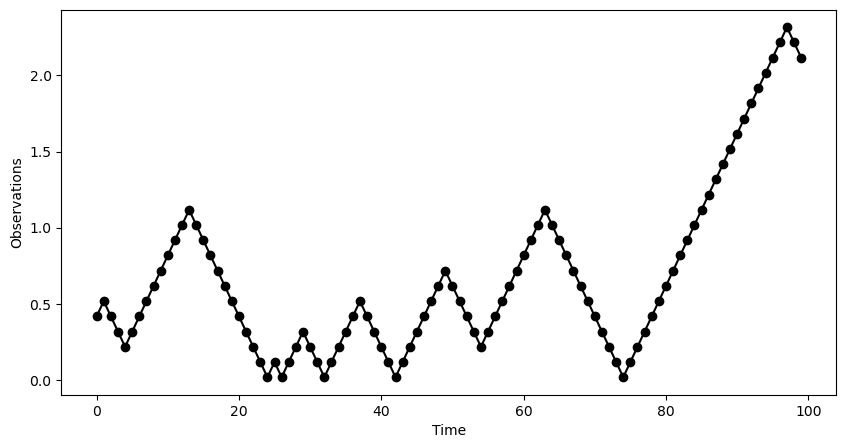

In [6]:
NSteps = 100
NTraj = 100

rate = 0.1
mplus = 0.1
mminus = -0.1
dt = 1
y0 = 1

observations = ObsModels.LinearRamps(NTraj, NSteps, rate, mplus, mminus, dt, initial_seed = 1)

features = []

for i in range(NTraj):
    features.append(np.array([np.ones(NSteps), observations[i]]))


fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [7]:
M = 2
A = 2

F = features[0].shape[0]

ThetaFollowSwitch = np.array([[[[10, 0.01], [0.01, 0.01]],
                               [[0.01, 0.01], [0.01, 10]]],
                              [[[0.01, 0.01], [0.01, 10]],
                               [[10, 0.01], [0.01, 0.01]]]])


Psi = np.array([1, 2])

FSC_exp = controller.FSC("continuous", M = 2, A = 2, F = F, mode = "generation", seed = 42,
                         psi = Psi, theta = ThetaFollowSwitch,
                         ActSpace = ActSpace, MemSpace = MemSpace)

In [8]:
FSC_exp.load_features(features)

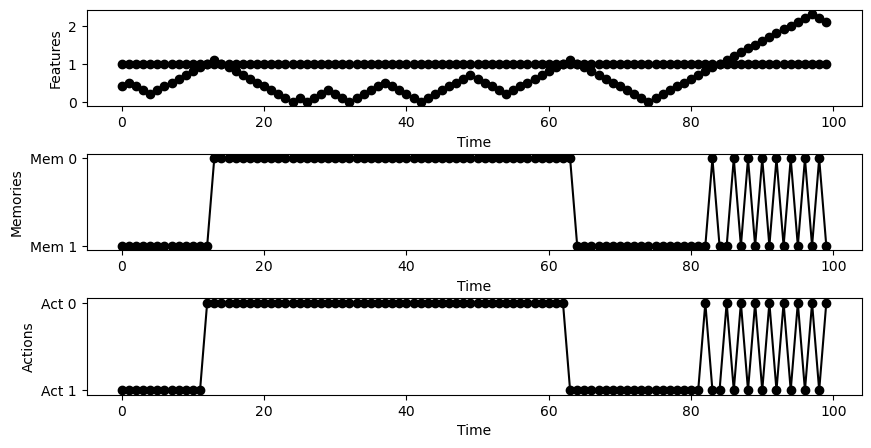

In [9]:
experimental_trajectories = FSC_exp.generate_trajectories(NSteps = NSteps)

idx_trj = 0
trj = experimental_trajectories[idx_trj]
fig, ax = FSC_exp.generator.plot_trajectory(trj)

In [10]:
experimental_trajectories_all = copy.deepcopy(experimental_trajectories)

for trj in experimental_trajectories:
    del trj["memories"]

In [11]:
nLL = 0

for trj in experimental_trajectories_all:
    nLL += FSC_exp.generator.evaluate_nloglikelihood(trj)

nLL/len(experimental_trajectories_all)

/Users/giorgionicoletti/Library/CloudStorage/OneDrive/ICTP/projects/InferenceFSCs/notebooks/tests/../../new_modules/ContinuousObs/generation.py:342: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  m = transition_probs @ rho


11.926194329937596

# Use-case example

In [12]:
FSC = controller.FSC("continuous", M = 2, A = 2, F = 2, seed = 42,
                     ActSpace = ActSpace, MemSpace = MemSpace)

In [13]:
NEpochs = 30
NBatch = 20
lr = (0.05, 0.05)
gamma = 0.99

tloss, vloss = FSC.fit(experimental_trajectories,
                       NEpochs = NEpochs, NBatch = NBatch, lr = lr, gamma = gamma)

Training with 80 trajectories and validating with 20 trajectories.
Epoch 1 - Training loss: 70.82748260498047, Validation loss: 59.99399738311767 - Learning rate: 0.05
Epoch 2 - Training loss: 55.649748992919925, Validation loss: 46.52026176452637 - Learning rate: 0.0495
Epoch 3 - Training loss: 46.23750534057618, Validation loss: 40.06670627593994 - Learning rate: 0.049005
Epoch 4 - Training loss: 42.159766387939456, Validation loss: 37.705871319770814 - Learning rate: 0.04851495
Epoch 5 - Training loss: 40.3785903930664, Validation loss: 36.24679913520813 - Learning rate: 0.0480298005
Epoch 6 - Training loss: 38.994477081298825, Validation loss: 35.00218822956085 - Learning rate: 0.047549502495
Epoch 7 - Training loss: 37.698638916015625, Validation loss: 33.729821753501895 - Learning rate: 0.04707400747005
Epoch 8 - Training loss: 36.434044647216794, Validation loss: 32.8210470199585 - Learning rate: 0.0466032673953495
Epoch 9 - Training loss: 35.627883148193355, Validation loss: 32

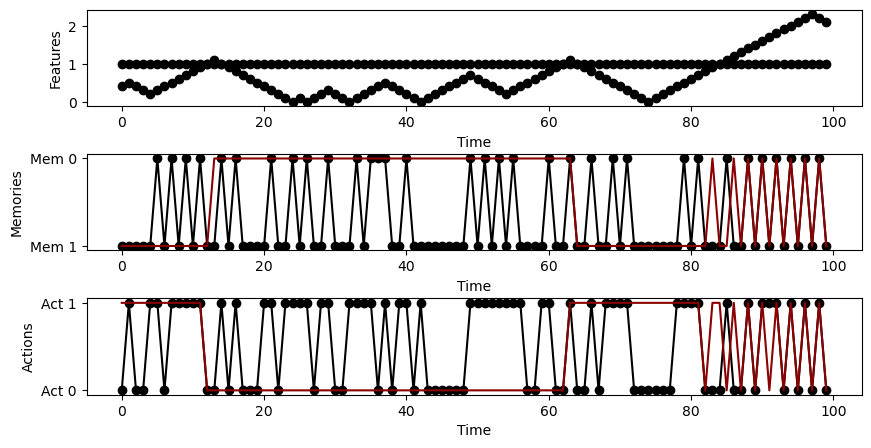

In [14]:
FSC.set_mode("generation")

generated_trajectories = FSC.generate_trajectories(NSteps)

idx_trj = 0
trj = generated_trajectories[idx_trj]
fig, ax = FSC.generator.plot_trajectory(trj)

ax[1].plot(experimental_trajectories_all[idx_trj]["memories"], label='Experimental', color='darkred')
ax[2].plot(experimental_trajectories_all[idx_trj]["actions"], label='Experimental', color='darkred')
plt.show()

In [16]:
FSC.set_mode("inference")
FSC.get_learned_parameters()

{'theta': array([[[[-1.1270374 , -0.95373344],
          [-0.12834148,  3.0099711 ]],
 
         [[-2.722636  ,  2.1041853 ],
          [ 2.601551  , -0.9169062 ]]],
 
 
        [[[-1.0696155 , -0.3752385 ],
          [-1.3593702 ,  0.7339777 ]],
 
         [[ 2.6657484 , -2.678602  ],
          [-2.5800889 , -2.0592475 ]]]], dtype=float32),
 'psi': array([-0.48858294, -0.2100016 ], dtype=float32)}